Implementing a Simple VAE using PyTorch
Import the modules neccessary to run

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
from ipdb import set_trace as st
from tqdm import tqdm

In [2]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


In [3]:
import sys
sys.argv=['']
del sys

we will define the argument parser to parse the command line arguments. We will provide the number of epochs to train for as the argument while executing the file from the command line. The following block of code constructs the argument parser.

In [4]:
# construct the argument parser and parser the arguments
parser = argparse.ArgumentParser(description='VAE Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

torch.manual_seed(args.seed)

# we use CPU for computation
device = torch.device("cpu")

#K = 1024
K = 500

Generate the standard toy "8-gaussians" dataset,

In [5]:
def gen_batch(BATCH_SIZE):
    theta = (np.pi/4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
    centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim = -1)
    noise = torch.randn_like(centers) * 0.1

    return centers + noise

def data_gen(BATCH_SIZE):
    #8 gaussians
    while 1:
        yield gen_batch(BATCH_SIZE)


we have to define the train and test data loaders. We can easily do that using the DataLoader module from PyTorch

In [6]:
test_loader = train_loader = data_gen(args.batch_size)

We will define the VAE
First we have the __init__() function
The VAE consists of an encoder that takes the  outputs 2 vectors of length latent_size
The reparametrize() function 
It has two parameters mu and log_var.
mu is the mean that is coming from encoder’s latent space encoding.
And logvar is the log variance that is coming from the encoder’s latent space.
first, we calculate the standard deviation (std) using the logvar.
Then , we calculate epsilon (eps) that we will use in the sample formula. We use torch.rand_like() so that dimensions will be same as std.
finally we calculate the sample using mu, eps, std. Then we return its value. 
Then we start forward() function
First,  pass the input through the VAE’s encoder layers. 
Then we get mu and log_var . These two have the same value as the encoder’s last layer output.
then, we get the latent vector z through reparameterization trick using mu and log_var.
next we have the decoding part. We pass the latent vector z through the first decoder layer. Then we get the reconstruction of the inputs by giving that output as input to the second decoder layer.
Finally,  return the reconstruction, mu, and logvar values.

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def sample(self, n=2048):
        """
        Generate n samples from the generative model.
        """
        sample = torch.randn(n, K).to(device)
        out = model.decode(sample)

        return out.cpu().detach().numpy()


    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

#    def decode(self, z):
#        h = F.relu(self.fc3(z))
#        mu = self.fc4(h)
#        logvar = self.fc5(h)
#        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
     #   mu_x, logvar_x = self.decode(z)
        return self.decode(z), mu, logvar



We will start initialing the model and loading it onto the computation device. Then we will define the optimizer and the loss function.We are using the Adam optimizer for training. then adjust the learning rate based on the number of epochs and with ReduceLROnPlateau allows dynamic learning rate reducing based on some validation measurements.

In [9]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, threshold = 1E-2, eps=1e-6)

we will write the function to calculate the total loss while training the autoencoder model.  it is going to be the addition of the KL Divergence loss and the reconstruction loss.
First we initialize the L2 loss at line 11.
then, we calculate the KL divergence using the mu and logvar values.
Finally, we return the total loss

In [10]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 2), reduction='sum')
    L2 = torch.mean((recon_x-x)**2)
  
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

We will define the training function here
first we initialize train_loss to keep track of the batch-wise loss values.
flattens the input data as we are going to feed it into a linear layer.
then, we get the reconstruction, mu, and log_var.
and calculates the reconstruction loss using the reconstructed data and the original input data.
after that we calculate the total loss using the total_loss function.
We calculate the batch loss . Then we backpropagate the gradients and update the parameters .
Finally, we calculate the total loss for the epoch (train_loss) and print its value.

Apply KernelDensity Estimation on recon_batch

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
   
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break #100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        recon_batch = recon_batch.detach().numpy()
       
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)


    samples_model = model.sample()
    samples_gt = gen_batch(2048)     
    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde_skl.fit(samples_gt)

    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(samples_model)
   # log_100.append(np.mean(log_pdf))

    print ("Epoch  average reconstruction error   :" ,epoch ,  train_loss )
    print (" likelihood  :", np.mean(log_pdf))
   # print (" likelihood  :", log_100)
    return train_loss, np.mean(log_pdf)


In [12]:
#update
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
           

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops. The EarlyStopping class in pytorchtool.py is used to create an object to keep track of the validation loss while training a PyTorch model. It will save a checkpoint of the model each time the validation loss decrease. We set the patience argument in the EarlyStopping class to how many epochs we want to wait after the last time the validation loss improved before breaking the training loop

In [13]:
#update
# import EarlyStopping
from pytorchtools import EarlyStopping

In [15]:
#update
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
             # calculate the loss
            loss = loss_function(recon_batch, data, mu, logvar)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
            # calculate the loss
            loss = loss_function(recon_batch, data, mu, logvar)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [20]:
#update
batch_size = 256
n_epochs = 100

#train_loader, test_loader, valid_loader = create_datasets(batch_size)
train_loader= test_loader= valid_loader = data_gen(args.batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

ValueError: too many values to unpack (expected 2)

In this section, I considered the recon_batch as input KernelDensity Estimation, and since the printed results are cluttered, for clarifying the first number is Epoch, the second number is reconstruction error, the third array is log_pdf(likelihood), and the fourth array is np.exp(log_pdf).

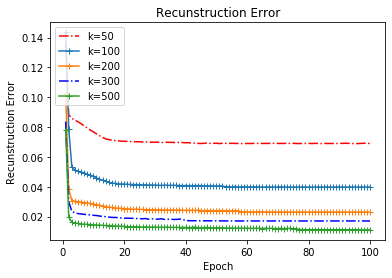

In [57]:
x = np.array(list(range(1, 101)))

plt.title('Recunstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Recunstruction Error')
plt.plot(x, train50, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=50")
plt.plot(x, train_100, marker = '+', linestyle = '-', label = 'k=100')
plt.plot(x, train_200, marker = '+', linestyle = '-', label = 'k=200')
plt.plot(x, train_300, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=300")
plt.plot(x, train_500,  marker = '+', linestyle = '-', label = 'k=500')
plt.legend(loc = "upper left")
plt.show()

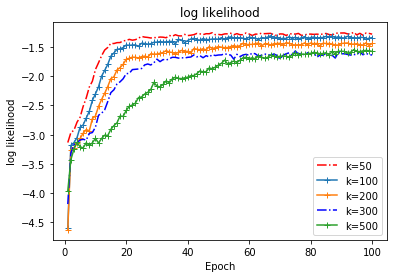

In [72]:
x = np.array(list(range(1, 101)))

plt.title('log likelihood')
plt.xlabel('Epoch')
plt.ylabel('log likelihood')
plt.plot(x, log50, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=50")
plt.plot(x, log_100, marker = '+', linestyle = '-', label = 'k=100')
plt.plot(x, log_200, marker = '+', linestyle = '-', label = 'k=200')
plt.plot(x, log_300, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=300")
plt.plot(x, log_500,  marker = '+', linestyle = '-', label = 'k=500')
plt.legend(loc = "lower right")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Starting training....


  1%|          | 1/100 [05:15<8:41:07, 315.83s/it]

Epoch  average reconstruction error   : 1 0.07799870854243636
 likelihood  : -3.959704052541335


  2%|▏         | 2/100 [10:16<8:28:28, 311.31s/it]

Epoch  average reconstruction error   : 2 0.01973266528919339
 likelihood  : -3.4257890047865116


  3%|▎         | 3/100 [15:10<8:14:48, 306.06s/it]

Epoch  average reconstruction error   : 3 0.01631158472970128
 likelihood  : -3.246862333211416


  4%|▍         | 4/100 [20:02<8:02:49, 301.76s/it]

Epoch  average reconstruction error   : 4 0.015531931342557072
 likelihood  : -3.132206247378979


  5%|▌         | 5/100 [24:58<7:55:15, 300.16s/it]

Epoch  average reconstruction error   : 5 0.015498931547626852
 likelihood  : -3.206239554764792


  6%|▌         | 6/100 [29:47<7:45:00, 296.81s/it]

Epoch  average reconstruction error   : 6 0.015065044965595006
 likelihood  : -3.225510027973675


  7%|▋         | 7/100 [34:43<7:39:36, 296.52s/it]

Epoch  average reconstruction error   : 7 0.014812371544539928
 likelihood  : -3.1367191619996317


  8%|▊         | 8/100 [39:38<7:34:06, 296.15s/it]

Epoch  average reconstruction error   : 8 0.014825930604711175
 likelihood  : -3.1840283451966442


  9%|▉         | 9/100 [44:38<7:30:41, 297.16s/it]

Epoch  average reconstruction error   : 9 0.014578322377055884
 likelihood  : -3.138174199309117


 10%|█         | 10/100 [49:30<7:23:28, 295.64s/it]

Epoch  average reconstruction error   : 10 0.014517799485474825
 likelihood  : -3.0618832575108867


 11%|█         | 11/100 [54:21<7:16:24, 294.20s/it]

Epoch  average reconstruction error   : 11 0.01430781077593565
 likelihood  : -3.1434561114775796


 12%|█▏        | 12/100 [59:20<7:13:42, 295.71s/it]

Epoch  average reconstruction error   : 12 0.014253993984311819
 likelihood  : -3.0643895011401074


 13%|█▎        | 13/100 [1:04:18<7:09:41, 296.34s/it]

Epoch  average reconstruction error   : 13 0.014134855465963483
 likelihood  : -3.007655728015009


 14%|█▍        | 14/100 [1:09:12<7:04:04, 295.86s/it]

Epoch  average reconstruction error   : 14 0.014020481891930104
 likelihood  : -3.01415813338002


 15%|█▌        | 15/100 [1:14:10<6:59:48, 296.34s/it]

Epoch  average reconstruction error   : 15 0.013915054174140096
 likelihood  : -2.9087398264925453


 16%|█▌        | 16/100 [1:19:02<6:52:56, 294.96s/it]

Epoch  average reconstruction error   : 16 0.013884138986468316
 likelihood  : -2.8444395629209267


 17%|█▋        | 17/100 [1:23:58<6:48:36, 295.38s/it]

Epoch  average reconstruction error   : 17 0.0136776003241539
 likelihood  : -2.796829065239738


 18%|█▊        | 18/100 [1:28:56<6:44:46, 296.18s/it]

Epoch  average reconstruction error   : 18 0.013562498316168785
 likelihood  : -2.681173105616483


 19%|█▉        | 19/100 [1:33:50<6:38:50, 295.44s/it]

Epoch  average reconstruction error   : 19 0.013494437402114272
 likelihood  : -2.6876313181194744


 20%|██        | 20/100 [1:38:49<6:35:27, 296.60s/it]

Epoch  average reconstruction error   : 20 0.013361084293574094
 likelihood  : -2.5853930225604653


 21%|██        | 21/100 [1:43:49<6:31:42, 297.50s/it]

Epoch  average reconstruction error   : 21 0.013316354146227241
 likelihood  : -2.513631554394485


 22%|██▏       | 22/100 [1:49:09<6:35:41, 304.38s/it]

Epoch  average reconstruction error   : 22 0.013199488660320639
 likelihood  : -2.4917053282029995


 23%|██▎       | 23/100 [1:54:19<6:32:56, 306.19s/it]

Epoch  average reconstruction error   : 23 0.01313616550527513
 likelihood  : -2.4590839044354427


 24%|██▍       | 24/100 [1:59:45<6:35:10, 311.98s/it]

Epoch  average reconstruction error   : 24 0.013126769280061125
 likelihood  : -2.365470322013018


 25%|██▌       | 25/100 [2:04:41<6:24:10, 307.34s/it]

Epoch  average reconstruction error   : 25 0.013062205258756876
 likelihood  : -2.354728587474747


 26%|██▌       | 26/100 [2:09:41<6:16:06, 304.95s/it]

Epoch  average reconstruction error   : 26 0.012975092642009259
 likelihood  : -2.3046814359563417


 27%|██▋       | 27/100 [2:14:31<6:05:47, 300.64s/it]

Epoch  average reconstruction error   : 27 0.013065021075308323
 likelihood  : -2.2767594405286373


 28%|██▊       | 28/100 [2:19:27<5:58:55, 299.10s/it]

Epoch  average reconstruction error   : 28 0.012901789303869008
 likelihood  : -2.2259959211773044


 29%|██▉       | 29/100 [2:24:27<5:54:09, 299.28s/it]

Epoch  average reconstruction error   : 29 0.01290472893975675
 likelihood  : -2.1057438676516895


 30%|███       | 30/100 [2:29:46<5:56:19, 305.42s/it]

Epoch  average reconstruction error   : 30 0.013035479793325066
 likelihood  : -2.1700646259714187


 31%|███       | 31/100 [2:41:49<8:15:04, 430.49s/it]

Epoch  average reconstruction error   : 31 0.012774287452921272
 likelihood  : -2.1831336894573425


 32%|███▏      | 32/100 [2:59:26<11:40:49, 618.38s/it]

Epoch  average reconstruction error   : 32 0.012885332321748138
 likelihood  : -2.1413198247961747


 33%|███▎      | 33/100 [3:11:30<12:06:11, 650.32s/it]

Epoch  average reconstruction error   : 33 0.01280006323941052
 likelihood  : -2.0797055283334744


 34%|███▍      | 34/100 [3:25:23<12:55:30, 705.00s/it]

Epoch  average reconstruction error   : 34 0.012949488032609225
 likelihood  : -2.114396610606683


 35%|███▌      | 35/100 [3:37:50<12:57:17, 717.49s/it]

Epoch  average reconstruction error   : 35 0.01273331199772656
 likelihood  : -2.044794469841705


 36%|███▌      | 36/100 [3:47:26<12:00:02, 675.04s/it]

Epoch  average reconstruction error   : 36 0.01277560031041503
 likelihood  : -2.0169945227695623


 37%|███▋      | 37/100 [3:52:25<9:50:36, 562.49s/it] 

Epoch  average reconstruction error   : 37 0.01273765992373228
 likelihood  : -2.0382171250659726


 38%|███▊      | 38/100 [3:57:23<8:19:11, 483.09s/it]

Epoch  average reconstruction error   : 38 0.01274836802855134
 likelihood  : -2.041204985333014


 39%|███▉      | 39/100 [4:02:18<7:13:47, 426.67s/it]

Epoch  average reconstruction error   : 39 0.01266422213986516
 likelihood  : -2.028375079209753


 40%|████      | 40/100 [4:07:10<6:26:08, 386.14s/it]

Epoch  average reconstruction error   : 40 0.012754190880805254
 likelihood  : -2.016953359748753


 41%|████      | 41/100 [4:12:06<5:53:04, 359.06s/it]

Epoch  average reconstruction error   : 41 0.012538438551127911
 likelihood  : -1.9915716418601348


 42%|████▏     | 42/100 [4:16:55<5:26:42, 337.97s/it]

Epoch  average reconstruction error   : 42 0.012639732891693711
 likelihood  : -1.9893947225746655


 43%|████▎     | 43/100 [4:21:50<5:08:52, 325.14s/it]

Epoch  average reconstruction error   : 43 0.01294687805697322
 likelihood  : -1.9560120034025483


 44%|████▍     | 44/100 [4:26:42<4:54:09, 315.18s/it]

Epoch  average reconstruction error   : 44 0.01254357629455626
 likelihood  : -1.909560498487382


 45%|████▌     | 45/100 [4:31:32<4:42:02, 307.69s/it]

Epoch  average reconstruction error   : 45 0.012441689297556877
 likelihood  : -1.9266246996723222


 46%|████▌     | 46/100 [4:36:24<4:32:48, 303.12s/it]

Epoch  average reconstruction error   : 46 0.01249041324481368
 likelihood  : -1.9220736994481056


 47%|████▋     | 47/100 [4:41:13<4:23:54, 298.76s/it]

Epoch  average reconstruction error   : 47 0.012707196837291122
 likelihood  : -1.8582521277268769


 48%|████▊     | 48/100 [4:46:08<4:18:05, 297.81s/it]

Epoch  average reconstruction error   : 48 0.012384176263585686
 likelihood  : -1.8740364490479973


 49%|████▉     | 49/100 [4:50:57<4:10:46, 295.03s/it]

Epoch  average reconstruction error   : 49 0.012395782014355063
 likelihood  : -1.845396816155414


 50%|█████     | 50/100 [4:56:48<4:19:44, 311.68s/it]

Epoch  average reconstruction error   : 50 0.012453876798972488
 likelihood  : -1.81173390276795


 51%|█████     | 51/100 [5:02:37<4:23:44, 322.95s/it]

Epoch  average reconstruction error   : 51 0.012425412675365805
 likelihood  : -1.7797476152682412


 52%|█████▏    | 52/100 [5:07:28<4:10:49, 313.54s/it]

Epoch  average reconstruction error   : 52 0.012412331914529205
 likelihood  : -1.7240020239742382
Epoch  average reconstruction error   : 53 0.012298170011490583
 likelihood  : -1.79314857055742


 54%|█████▍    | 54/100 [5:17:03<3:49:57, 299.94s/it]

Epoch  average reconstruction error   : 54 0.012261324506253004
 likelihood  : -1.7672879522907694


 55%|█████▌    | 55/100 [5:21:56<3:43:33, 298.07s/it]

Epoch  average reconstruction error   : 55 0.012410438926890493
 likelihood  : -1.7393313224337754


 56%|█████▌    | 56/100 [5:26:54<3:38:31, 297.99s/it]

Epoch  average reconstruction error   : 56 0.012161577604711055
 likelihood  : -1.7670228649179036


 57%|█████▋    | 57/100 [5:31:39<3:30:45, 294.07s/it]

Epoch  average reconstruction error   : 57 0.012259689373895526
 likelihood  : -1.7266964439753172


 58%|█████▊    | 58/100 [5:36:33<3:25:52, 294.10s/it]

Epoch  average reconstruction error   : 58 0.012211850471794605
 likelihood  : -1.6849306030987286


 59%|█████▉    | 59/100 [5:41:35<3:22:32, 296.41s/it]

Epoch  average reconstruction error   : 59 0.01222049699164927
 likelihood  : -1.6760441769103611


 60%|██████    | 60/100 [5:46:29<3:17:03, 295.58s/it]

Epoch  average reconstruction error   : 60 0.012193094193935394
 likelihood  : -1.7039130381697962


 61%|██████    | 61/100 [5:51:24<3:12:01, 295.42s/it]

Epoch  average reconstruction error   : 61 0.012066298127174378
 likelihood  : -1.684582464631618


 62%|██████▏   | 62/100 [5:56:25<3:08:09, 297.10s/it]

Epoch  average reconstruction error   : 62 0.012116008708253502
 likelihood  : -1.704792529632981


 63%|██████▎   | 63/100 [6:01:15<3:01:58, 295.09s/it]

Epoch  average reconstruction error   : 63 0.012195735611021519
 likelihood  : -1.6527683956717412


 64%|██████▍   | 64/100 [6:06:07<2:56:28, 294.12s/it]

Epoch  average reconstruction error   : 64 0.012149393437430262
 likelihood  : -1.674225787054589


 65%|██████▌   | 65/100 [6:11:06<2:52:19, 295.42s/it]

Epoch  average reconstruction error   : 65 0.011973916217684746
 likelihood  : -1.6928908645630445


 66%|██████▌   | 66/100 [6:15:54<2:46:14, 293.38s/it]

Epoch  average reconstruction error   : 66 0.012172435997053982
 likelihood  : -1.679150676729069


 67%|██████▋   | 67/100 [6:20:47<2:41:19, 293.32s/it]

Epoch  average reconstruction error   : 67 0.012034692689776421
 likelihood  : -1.637299604698296


 68%|██████▊   | 68/100 [6:25:45<2:37:08, 294.63s/it]

Epoch  average reconstruction error   : 68 0.012192457970231772
 likelihood  : -1.6519922371612714


 69%|██████▉   | 69/100 [6:30:30<2:30:40, 291.64s/it]

Epoch  average reconstruction error   : 69 0.011878208881244063
 likelihood  : -1.6722524006172992


 70%|███████   | 70/100 [6:35:28<2:26:48, 293.61s/it]

Epoch  average reconstruction error   : 70 0.011968177007511259
 likelihood  : -1.6589879142166597


 71%|███████   | 71/100 [6:40:16<2:21:04, 291.89s/it]

Epoch  average reconstruction error   : 71 0.012058202419430017
 likelihood  : -1.6591141005342989


 72%|███████▏  | 72/100 [6:45:02<2:15:24, 290.17s/it]

Epoch  average reconstruction error   : 72 0.011892276536673307
 likelihood  : -1.657112004947561


 73%|███████▎  | 73/100 [6:49:48<2:10:02, 288.97s/it]

Epoch  average reconstruction error   : 73 0.012012925585731865
 likelihood  : -1.6775322552785008


 74%|███████▍  | 74/100 [6:54:38<2:05:16, 289.10s/it]

Epoch  average reconstruction error   : 74 0.012061997111886739
 likelihood  : -1.6401669932447915


 75%|███████▌  | 75/100 [6:59:22<1:59:52, 287.71s/it]

Epoch  average reconstruction error   : 75 0.011867682142183185
 likelihood  : -1.6010547919151432
Epoch    76: reducing learning rate of group 0 to 1.0000e-04.


 76%|███████▌  | 76/100 [7:04:06<1:54:36, 286.50s/it]

Epoch  average reconstruction error   : 76 0.011902220295742155
 likelihood  : -1.6341239254149227


 77%|███████▋  | 77/100 [7:08:55<1:50:08, 287.32s/it]

Epoch  average reconstruction error   : 77 0.011285477196797728
 likelihood  : -1.6231876159645657


 78%|███████▊  | 78/100 [7:13:38<1:44:53, 286.05s/it]

Epoch  average reconstruction error   : 78 0.011212242199108005
 likelihood  : -1.625942712367383


 79%|███████▉  | 79/100 [7:18:25<1:40:11, 286.26s/it]

Epoch  average reconstruction error   : 79 0.011195542123168707
 likelihood  : -1.6182997446529455


 80%|████████  | 80/100 [7:23:12<1:35:31, 286.59s/it]

Epoch  average reconstruction error   : 80 0.011184273874387146
 likelihood  : -1.6092859330053353


 81%|████████  | 81/100 [7:28:03<1:31:10, 287.92s/it]

Epoch  average reconstruction error   : 81 0.011187314093112945
 likelihood  : -1.59546889397707


 82%|████████▏ | 82/100 [7:32:55<1:26:43, 289.11s/it]

Epoch  average reconstruction error   : 82 0.011178203877061605
 likelihood  : -1.5994608202897478


 83%|████████▎ | 83/100 [7:37:45<1:21:57, 289.26s/it]

Epoch  average reconstruction error   : 83 0.011181256659328937
 likelihood  : -1.6179739270509939


 84%|████████▍ | 84/100 [7:42:30<1:16:49, 288.12s/it]

Epoch  average reconstruction error   : 84 0.011176937920972706
 likelihood  : -1.611836557960174


 85%|████████▌ | 85/100 [7:47:20<1:12:11, 288.75s/it]

Epoch  average reconstruction error   : 85 0.011168018123134971
 likelihood  : -1.5998101854078057


 86%|████████▌ | 86/100 [7:52:12<1:07:36, 289.77s/it]

Epoch  average reconstruction error   : 86 0.011158937057480216
 likelihood  : -1.6364849101785142


 87%|████████▋ | 87/100 [7:57:02<1:02:46, 289.75s/it]

Epoch  average reconstruction error   : 87 0.01115771759301424
 likelihood  : -1.57678809215084


 88%|████████▊ | 88/100 [8:01:53<58:00, 290.03s/it]  

Epoch  average reconstruction error   : 88 0.011163517395034432
 likelihood  : -1.6224873870463403


 89%|████████▉ | 89/100 [8:06:47<53:24, 291.33s/it]

Epoch  average reconstruction error   : 89 0.01115494198165834
 likelihood  : -1.5732514424852821


 90%|█████████ | 90/100 [8:11:36<48:26, 290.65s/it]

Epoch  average reconstruction error   : 90 0.011157603804022073
 likelihood  : -1.5744452437223717


 91%|█████████ | 91/100 [8:16:33<43:53, 292.59s/it]

Epoch  average reconstruction error   : 91 0.011158341523259879
 likelihood  : -1.5772761016270056


 92%|█████████▏| 92/100 [8:21:25<38:58, 292.27s/it]

Epoch  average reconstruction error   : 92 0.01115065854974091
 likelihood  : -1.6050218628391741


 93%|█████████▎| 93/100 [8:26:23<34:17, 293.97s/it]

Epoch  average reconstruction error   : 93 0.011138105373829603
 likelihood  : -1.5891517553438375


 94%|█████████▍| 94/100 [8:31:16<29:21, 293.61s/it]

Epoch  average reconstruction error   : 94 0.011150418603792787
 likelihood  : -1.5476403795583065


 95%|█████████▌| 95/100 [8:36:15<24:36, 295.34s/it]

Epoch  average reconstruction error   : 95 0.011141545195132494
 likelihood  : -1.576161052152528
Epoch    96: reducing learning rate of group 0 to 1.0000e-05.


 96%|█████████▌| 96/100 [8:40:55<19:22, 290.73s/it]

Epoch  average reconstruction error   : 96 0.011145412446931005
 likelihood  : -1.581788919349072


 97%|█████████▋| 97/100 [8:45:50<14:36, 292.02s/it]

Epoch  average reconstruction error   : 97 0.011081001935526729
 likelihood  : -1.5670558893527442


 98%|█████████▊| 98/100 [8:50:32<09:38, 289.06s/it]

Epoch  average reconstruction error   : 98 0.011077882619574667
 likelihood  : -1.5596118799040988


 99%|█████████▉| 99/100 [8:55:28<04:51, 291.12s/it]

Epoch  average reconstruction error   : 99 0.011068758834153414
 likelihood  : -1.5658692345762537


100%|██████████| 100/100 [9:00:16<00:00, 324.17s/it]

Epoch  average reconstruction error   : 100 0.011049689901992678
 likelihood  : -1.577645810385747
train1 [0.07799870854243636, 0.01973266528919339, 0.01631158472970128, 0.015531931342557072, 0.015498931547626852, 0.015065044965595006, 0.014812371544539928, 0.014825930604711175, 0.014578322377055884, 0.014517799485474825, 0.01430781077593565, 0.014253993984311819, 0.014134855465963483, 0.014020481891930104, 0.013915054174140096, 0.013884138986468316, 0.0136776003241539, 0.013562498316168785, 0.013494437402114272, 0.013361084293574094, 0.013316354146227241, 0.013199488660320639, 0.01313616550527513, 0.013126769280061125, 0.013062205258756876, 0.012975092642009259, 0.013065021075308323, 0.012901789303869008, 0.01290472893975675, 0.013035479793325066, 0.012774287452921272, 0.012885332321748138, 0.01280006323941052, 0.012949488032609225, 0.01273331199772656, 0.01277560031041503, 0.01273765992373228, 0.01274836802855134, 0.01266422213986516, 0.012754190880805254, 0.012538438551127911, 0.012


__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


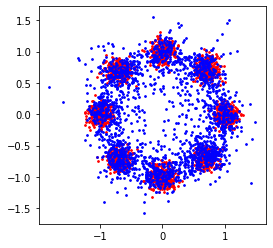

In [27]:
# k = 500, epoch 100
if __name__ == "__main__":
    print("Starting training....")
    train_500 = []
    log_500 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_500.append(a)
        log_500.append(b)
        
  
    print("train1", train_500, log_500)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [38]:
train_500 = np.array([0.07799870854243636,
 0.01973266528919339,
 0.01631158472970128,
 0.015531931342557072,
 0.015498931547626852,
 0.015065044965595006,
 0.014812371544539928,
 0.014825930604711175,
 0.014578322377055884,
 0.014517799485474825,
 0.01430781077593565,
 0.014253993984311819,
 0.014134855465963483,
 0.014020481891930104,
 0.013915054174140096,
 0.013884138986468316,
 0.0136776003241539,
 0.013562498316168785,
 0.013494437402114272,
 0.013361084293574094,
 0.013316354146227241,
 0.013199488660320639,
 0.01313616550527513,
 0.013126769280061125,
 0.013062205258756876,
 0.012975092642009259,
 0.013065021075308323,
 0.012901789303869008,
 0.01290472893975675,
 0.013035479793325066,
 0.012774287452921272,
 0.012885332321748138,
 0.01280006323941052,
 0.012949488032609225,
 0.01273331199772656,
 0.01277560031041503,
 0.01273765992373228,
 0.01274836802855134,
 0.01266422213986516,
 0.012754190880805254,
 0.012538438551127911,
 0.012639732891693711,
 0.01294687805697322,
 0.01254357629455626,
 0.012441689297556877,
 0.01249041324481368,
 0.012707196837291122,
 0.012384176263585686,
 0.012395782014355063,
 0.012453876798972488,
 0.012425412675365805,
 0.012412331914529205,
 0.012298170011490583,
 0.012261324506253004,
 0.012410438926890493,
 0.012161577604711055,
 0.012259689373895526,
 0.012211850471794605,
 0.01222049699164927,
 0.012193094193935394,
 0.012066298127174378,
 0.012116008708253502,
 0.012195735611021519,
 0.012149393437430262,
 0.011973916217684746,
 0.012172435997053982,
 0.012034692689776421,
 0.012192457970231772,
 0.011878208881244063,
 0.011968177007511259,
 0.012058202419430017,
 0.011892276536673307,
 0.012012925585731865,
 0.012061997111886739,
 0.011867682142183185,
 0.011902220295742155,
 0.011285477196797728,
 0.011212242199108005,
 0.011195542123168707,
 0.011184273874387146,
 0.011187314093112945,
 0.011178203877061605,
 0.011181256659328937,
 0.011176937920972706,
 0.011168018123134971,
 0.011158937057480216,
 0.01115771759301424,
 0.011163517395034432,
 0.01115494198165834,
 0.011157603804022073,
 0.011158341523259879,
 0.01115065854974091,
 0.011138105373829603,
 0.011150418603792787,
 0.011141545195132494,
 0.011145412446931005,
 0.011081001935526729,
 0.011077882619574667,
 0.011068758834153414,
 0.011049689901992678])


In [39]:
log_500 = np.array([-3.959704052541335,
 -3.4257890047865116,
 -3.246862333211416,
 -3.132206247378979,
 -3.206239554764792,
 -3.225510027973675,
 -3.1367191619996317,
 -3.1840283451966442,
 -3.138174199309117,
 -3.0618832575108867,
 -3.1434561114775796,
 -3.0643895011401074,
 -3.007655728015009,
 -3.01415813338002,
 -2.9087398264925453,
 -2.8444395629209267,
 -2.796829065239738,
 -2.681173105616483,
 -2.6876313181194744,
 -2.5853930225604653,
 -2.513631554394485,
 -2.4917053282029995,
 -2.4590839044354427,
 -2.365470322013018,
 -2.354728587474747,
 -2.3046814359563417,
 -2.2767594405286373,
 -2.2259959211773044,
 -2.1057438676516895,
 -2.1700646259714187,
 -2.1831336894573425,
 -2.1413198247961747,
 -2.0797055283334744,
 -2.114396610606683,
 -2.044794469841705,
 -2.0169945227695623,
 -2.0382171250659726,
 -2.041204985333014,
 -2.028375079209753,
 -2.016953359748753,
 -1.9915716418601348,
 -1.9893947225746655,
 -1.9560120034025483,
 -1.909560498487382,
 -1.9266246996723222,
 -1.9220736994481056,
 -1.8582521277268769,
 -1.8740364490479973,
 -1.845396816155414,
 -1.81173390276795,
 -1.7797476152682412,
 -1.7240020239742382,
 -1.79314857055742,
 -1.7672879522907694,
 -1.7393313224337754,
 -1.7670228649179036,
 -1.7266964439753172,
 -1.6849306030987286,
 -1.6760441769103611,
 -1.7039130381697962,
 -1.684582464631618,
 -1.704792529632981,
 -1.6527683956717412,
 -1.674225787054589,
 -1.6928908645630445,
 -1.679150676729069,
 -1.637299604698296,
 -1.6519922371612714,
 -1.6722524006172992,
 -1.6589879142166597,
 -1.6591141005342989,
 -1.657112004947561,
 -1.6775322552785008,
 -1.6401669932447915,
 -1.6010547919151432,
 -1.6341239254149227,
 -1.6231876159645657,
 -1.625942712367383,
 -1.6182997446529455,
 -1.6092859330053353,
 -1.59546889397707,
 -1.5994608202897478,
 -1.6179739270509939,
 -1.611836557960174,
 -1.5998101854078057,
 -1.6364849101785142,
 -1.57678809215084,
 -1.6224873870463403,
 -1.5732514424852821,
 -1.5744452437223717,
 -1.5772761016270056,
 -1.6050218628391741,
 -1.5891517553438375,
 -1.5476403795583065,
 -1.576161052152528,
 -1.581788919349072,
 -1.5670558893527442,
 -1.5596118799040988,
 -1.5658692345762537,
 -1.577645810385747])